In [1]:
import numpy as np
import matplotlib.pyplot as plt
from seaborn import set_palette
flatui = ["#3498db", "#9b59b6", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
set_palette(flatui)
%matplotlib inline
%config InlineBackend.figure_format = "retina"
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = 'gray'
plt.rcParams['grid.linewidth'] = 0.25
plt.rcParams['grid.alpha'] = 0.2
plt.style.use('seaborn-talk')

from scipy.signal import stft, istft, get_window
from IPython.display import Audio
from tqdm import tnrange, tqdm_notebook

random_seed = 0

In [2]:
import os
from os import listdir
from os.path import join
datapath = "CMU_ARCTIC/cmu_us_bdl_arctic/wav"
train_data_folder = join(datapath, 'train')
test_data_folder = join(datapath, 'test')

from scipy.io import wavfile
from IPython.display import Audio
train_data = []
test_data = []
train_data_filenames = [f for f in listdir(train_data_folder) if os.path.isfile( join(train_data_folder, f))]
test_data_filenames = [f for f in listdir(test_data_folder) if os.path.isfile( join(test_data_folder, f))]

for i_train_data_filename in range(len(train_data_filenames)):
    f_path = join(train_data_folder, train_data_filenames[i_train_data_filename])
    if f_path.endswith('.wav'):
        sampling_frequency, train_data_example = wavfile.read(f_path)
    train_data.append(train_data_example)
    
for i_test_data_filename in range(len(test_data_filenames)):
    f_path = join(test_data_folder, test_data_filenames[i_test_data_filename])
    if f_path.endswith('.wav'):
        sampling_frequency, test_data_example = wavfile.read(f_path)
    test_data.append(test_data_example)

In [3]:
# Microphone positions
pos_x = np.arange(-0.8, 0.8+1e-6, 0.2)
n_mics = len(pos_x)
pos_y = np.zeros(n_mics)
pos_z = np.zeros(n_mics)
mic_pos = np.row_stack((pos_x, pos_y, pos_z))

In [4]:
SOUND_SPEED = 340 # [m/s]
sampling_frequency = 16000 # [Hz]
n_samples_per_frame = 512
n_fft_bins = (int) (n_samples_per_frame / 2) 
hop_size = (int) (n_samples_per_frame / 2)
stft_window = get_window("hann", n_samples_per_frame)

In [5]:
# Source angles
theta_s = np.array([-10]) # [degree]
phi_s = np.array([0]) # [degree]

In [6]:
theta_grid = np.arange(-90, 90+1e-6, 0.1) # [degree]
phi_grid = np.array([0]) # [degree]

# Steering vectors
def compute_steering_vectors_single_frequency(mic_pos, frequency, theta_grid, phi_grid):
    # wave number
    k = 2*np.pi*frequency/SOUND_SPEED

    n_mics = len(mic_pos[0])
    theta_grid = theta_grid * np.pi/180 # [degree] to [radian]
    phi_grid = phi_grid * np.pi/180 # [degree] to [radian]
    
    u = np.sin(theta_grid.reshape(-1, 1)).dot(np.cos(phi_grid).reshape(1, -1))
    v = np.sin(theta_grid.reshape(-1, 1)).dot(np.sin(phi_grid).reshape(1, -1))
    w = np.tile(np.cos(theta_grid.reshape(-1, 1)), (1, phi_grid.shape[0]))

    x = u.reshape(u.shape[0], u.shape[1], 1)*mic_pos[0].reshape(1, 1, n_mics)
    y = v.reshape(v.shape[0], v.shape[1], 1)*mic_pos[1].reshape(1, 1, n_mics)
    z = w.reshape(w.shape[0], w.shape[1], 1)*mic_pos[2].reshape(1, 1, n_mics)

    return np.exp( -1j*k*(x + y + z))

def compute_steering_vectors(mic_pos, sampling_frequency, n_fft, theta_grid, phi_grid):
    n_thetas = len(theta_grid)
    n_phis = len(phi_grid)
    n_mics = len(mic_pos[0])
    steering_vectors = np.zeros((n_fft, n_thetas, n_phis, n_mics), dtype=np.complex64)
    for i_fft in range(n_fft):
        frequency = (i_fft / n_fft) * (sampling_frequency)
        steering_vectors[i_fft] = compute_steering_vectors_single_frequency(mic_pos, frequency, theta_grid, phi_grid)
        
    return steering_vectors

def compute_sinr_2(source_tf_multichannel, interference_tf_multichannel):
        source_power = 0
        interference_power = 0
        n_fft_bins = source_tf_multichannel.shape[0]
        for i_f in range(n_fft_bins):
            source_power += np.trace(source_stft_multichannel[i_f].dot(source_stft_multichannel[i_f].transpose().conjugate()))
            interference_power += np.trace(interference_stft_multichannel[i_f].dot(interference_stft_multichannel[i_f].transpose().conjugate()))
        return 10*np.log10(np.abs(source_power/interference_power))
    
def compute_sinr(source_tf_multichannel, interference_tf_multichannel, weights=None):
    n_fft_bins, n_mics, _ = source_tf_multichannel.shape
    source_power = 0
    interference_power = 0
    if weights is not None:
        for i_f in range(n_fft_bins):
            source_power += weights[i_f].reshape(n_mics, 1).transpose().conjugate().dot(
                source_tf_multichannel[i_f].dot(
                source_tf_multichannel[i_f].transpose().conjugate())).dot(
                weights[i_f].reshape(n_mics, 1))
            interference_power += weights[i_f].transpose().conjugate().dot(
                interference_tf_multichannel[i_f].dot(
                interference_tf_multichannel[i_f].transpose().conjugate())).dot(
                weights[i_f])
    else:
        for i_f in range(n_fft_bins):
            source_power += np.trace(source_tf_multichannel[i_f].dot(source_tf_multichannel[i_f].transpose().conjugate()))
            interference_power += np.trace(interference_tf_multichannel[i_f].dot(interference_tf_multichannel[i_f].transpose().conjugate()))
    return 10*np.log10(np.abs(source_power/interference_power))
    
def compute_mvdr_tf_beamformers(source_steering_vectors, tf_frames_multichannel):
    n_fft_bins, n_mics = source_steering_vectors.shape
    mvdr_tf_beamformers = np.zeros((n_fft_bins, n_mics), dtype=np.complex64)
    for i_fft_bin in range(n_fft_bins):
        R = tf_frames_multichannel[i_fft_bin].dot(tf_frames_multichannel[i_fft_bin].transpose().conjugate()) + np.identity(n_mics)
        invR = np.linalg.inv(R)
        normalization_factor = source_steering_vectors[i_fft_bin, :].transpose().conjugate().dot(invR).dot(source_steering_vectors[i_fft_bin, :])
        mvdr_tf_beamformers[i_fft_bin] = invR.dot(source_steering_vectors[i_fft_bin, :]) / normalization_factor
    return mvdr_tf_beamformers

def simulate_multichannel_tf(signal, theta, phi):
    steering_vector = ( compute_steering_vectors(mic_pos, sampling_frequency, n_fft_bins, theta, phi) )[:, 0, 0, :]
    _, _, tf_frames = stft(signal.reshape(-1), fs=sampling_frequency, window=stft_window,
                             nperseg=n_samples_per_frame, noverlap=n_samples_per_frame-hop_size,
                             nfft=n_samples_per_frame, padded=True)
    tf_frames = tf_frames[:-1, 1:-1]
    tf_frames_multichannel = steering_vector.reshape(n_fft_bins, n_mics, 1)\
                                * tf_frames.reshape(tf_frames.shape[0], 1, tf_frames.shape[1])
    return tf_frames_multichannel

def check_distortless_constraint(weight, source_steering_vector):
    assert(np.abs(weight.transpose().conjugate().dot(source_steering_vector)) - 1 < 1e-9)

In [7]:
steering_vectors = compute_steering_vectors(mic_pos, sampling_frequency=sampling_frequency, 
                                    n_fft=n_fft_bins, theta_grid=theta_grid, phi_grid=phi_grid)
source_steering_vectors = compute_steering_vectors(mic_pos, sampling_frequency, n_fft_bins, 
    np.array([theta_s[0]]), np.array([phi_s[0]]))

### Train MVDR baseline dictionary

In [8]:
np.random.seed(random_seed)
n_interference_list = [1, 2]

training_thetas = list(np.arange(-90, 90, 30))

training_phis = [0]

import itertools
training_interference_data = []
training_noise_interference_data = []
np.random.seed(random_seed)

for i_n_interference in tqdm_notebook(range(len(n_interference_list)), desc="Interference number"):
    n_interferences = n_interference_list[i_n_interference]
    interferences_params = []
    for i_interference in range(n_interferences):
        interference_params = list(itertools.product(*[training_thetas, training_phis]))
        interferences_params.append(interference_params)
    interferences_param_sets = list(itertools.product(*interferences_params))

    for i_param_set in tqdm_notebook(range(len(interferences_param_sets)), desc="Parameter set"):    
        param_set = interferences_param_sets[i_param_set]
        n_training_samples = 20
        for i_training_sample in range(n_training_samples):
            interference_signals = []
            for i_interference in range(len(param_set)):
                interference_signal = train_data[np.random.choice(len(train_data))]
                interference_signals.append(interference_signal)                
            interference_n_samples = min([len(signal) for signal in interference_signals])
            
            interference_tf_multichannel_list = []
            for i_interference in range(len(param_set)):
                interference_signals[i_interference] = (interference_signals[i_interference])[0:interference_n_samples]
                interference_theta, interference_phi = param_set[i_interference]
                interference_theta += 2*np.random.uniform()
                interference_tf_multichannel = simulate_multichannel_tf(interference_signal, 
                        np.array([interference_theta]), np.array([interference_phi]))
                interference_tf_multichannel_list.append(interference_tf_multichannel)
            training_interference_data.append(sum(interference_tf_multichannel_list))

In [9]:
class BaseDLBeamformer(object):
    def __init__(self, vs, bf_type="MVDR"):
        """
        Parameters
        ----------
        vs: Source manifold array vector
        bf_type: Type of beamformer
        """
        self.vs = vs
        self.bf_type = bf_type
        self.weights_ = None
        
    def _compute_weights(self, training_data):
        n_training_samples = len(training_data)
        n_fft_bins, n_mics, _ = training_data[0].shape
        D = np.zeros((n_fft_bins, n_mics, n_training_samples), dtype=complex)
        for i_training_sample in tqdm_notebook(range(n_training_samples), desc="Training sample"):
            tf_frames_multichannel = training_data[i_training_sample]
            if self.bf_type == "MVDR":
                w = compute_mvdr_tf_beamformers(self.vs, tf_frames_multichannel)
#                 check_distortless_constraint(w, self.vs)
            D[:, :, i_training_sample] = w
            
        return D

    def _initialize(self, X):
        pass

    def _choose_weights(self, x):
        n_dictionary_atoms = self.weights_.shape[2]
        min_ave_energy = np.inf
        optimal_weight_index = None
        for i_dictionary_atom in range(n_dictionary_atoms):
            w_frequency = self.weights_[:, :, i_dictionary_atom]
            energy = 0
            for i_fft_bin in range(n_fft_bins):
                w = w_frequency[i_fft_bin]
                R = x[i_fft_bin].dot(x[i_fft_bin].transpose().conjugate())
                energy += np.real(w.transpose().conjugate().dot(R).dot(w))
            ave_energy = energy / n_fft_bins
            if min_ave_energy > ave_energy:
                min_ave_energy = ave_energy
                optimal_weight_index = i_dictionary_atom
        optimal_weight = self.weights_[:, :, optimal_weight_index]
        return optimal_weight, optimal_weight_index
    
    def fit(self, training_data):
        """
        Parameters
        ----------
        X: shape = [n_samples, n_features]
        """
        D = self._compute_weights(training_data)
        self.weights_ = D
        return self

    def choose_weights(self, x):
        return self._choose_weights(x)

In [10]:
dictionary = BaseDLBeamformer(source_steering_vectors[:, 0, 0, :])
dictionary.fit(training_interference_data);

In [11]:
# Simulate received multichannel signal
np.random.seed(0)

# Test signals    
n_test_samples = 40000
source_signal = test_data[0][0:n_test_samples]
interference_signals = []
for i_interference in range(2):
    interference_signals.append(test_data[i_interference+1][0:n_test_samples])
    
# Interference angles
thetas_i = np.array([30.2]) # [degree]
phis_i =np.array([0]) # [degree]

time_samples = np.arange(0, n_test_samples)/sampling_frequency    

source_stft_multichannel = simulate_multichannel_tf(source_signal, theta_s, phi_s)

received_stft_multichannel = np.zeros(source_stft_multichannel.shape, dtype=np.complex64)

received_stft_multichannel += source_stft_multichannel

interference_stfts_multichannel_list = []

for i_angle in range(len(thetas_i)):
    interference_signal = interference_signals[i_angle]
    
    interference_stft_multichannel = simulate_multichannel_tf(interference_signal, np.array([thetas_i[i_angle]]), np.array([phis_i[i_angle]]))

    interference_stfts_multichannel_list.append(interference_stft_multichannel)
    
    received_stft_multichannel += interference_stft_multichannel
    
interference_stfts_multichannel = sum(interference_stfts_multichannel_list)

Input SINR: 6.43 dB


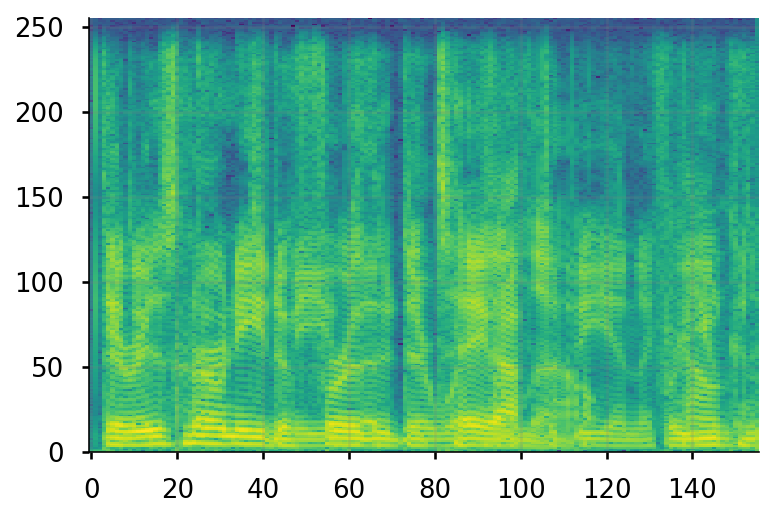

In [12]:
# Listen to the simulated received signal
t, ss = istft(np.real(received_stft_multichannel[:, 0, :]), fs=sampling_frequency, window=stft_window,
                         nperseg=n_samples_per_frame, noverlap=n_samples_per_frame-hop_size,
                         nfft=n_samples_per_frame, boundary=True)

plt.imshow(10*np.log10(np.abs(received_stft_multichannel[:, 0, :])), origin='lower', aspect='auto')
input_sinr = compute_sinr(source_stft_multichannel, interference_stft_multichannel)
print("Input SINR: {:.2f} dB".format(input_sinr))
Audio(np.real(ss), rate=sampling_frequency, autoplay=True)

In [13]:
# Compute input SINR
sig_pow = 0
inter_pow = 0
for i_f in range(n_fft_bins):
    sig_pow += np.trace(source_stft_multichannel[i_f].dot(source_stft_multichannel[i_f].transpose().conjugate()))
    inter_pow += np.trace(interference_stft_multichannel[i_f].dot(interference_stft_multichannel[i_f].transpose().conjugate()))
# interference_stft_multichannel[:, 0, :].shape
out = 10*np.log10(np.abs(sig_pow)/np.abs(inter_pow))
# 10*np.log10(np.abs(inter_pow))
compute_sinr(source_stft_multichannel, interference_stft_multichannel) - compute_sinr_2(source_stft_multichannel, interference_stft_multichannel)

0.0

### Beamformers and outputs

Output SINR: 20.59 dB


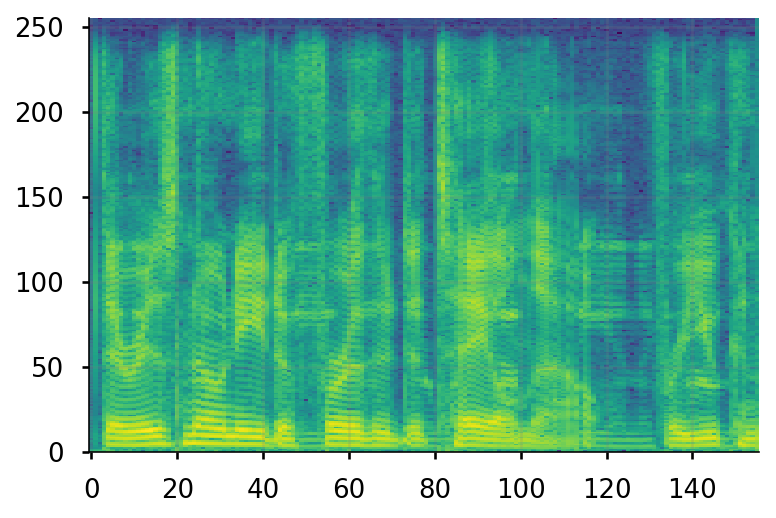

In [14]:
# Delay-sum beamformer
ds_tf_beamformers = 1./n_mics * source_steering_vectors
ds_tf_out = np.zeros((n_fft_bins, received_stft_multichannel.shape[2]), dtype=np.complex64)
for i_fft_bin in range(n_fft_bins):
    ds_tf_out[i_fft_bin] = ds_tf_beamformers[i_fft_bin, 0, 0].transpose().conjugate().dot(received_stft_multichannel[i_fft_bin])
t, ds_out_2 = istft(ds_tf_out, fs=sampling_frequency, window=stft_window,
                         nperseg=n_samples_per_frame, noverlap=n_samples_per_frame-hop_size,
                         nfft=n_samples_per_frame, boundary=True)    

plt.imshow(10*np.log10(np.abs(ds_tf_out)), origin='lower', aspect='auto')
ds_out_sinr = compute_sinr(source_stft_multichannel, interference_stft_multichannel, ds_tf_beamformers[:, 0, 0, :])
print("Output SINR: {:.2f} dB".format(ds_out_sinr[0][0]))
Audio(np.real(ds_out_2), rate=sampling_frequency, autoplay=True)

MPDR output SINR: 15.64 dB


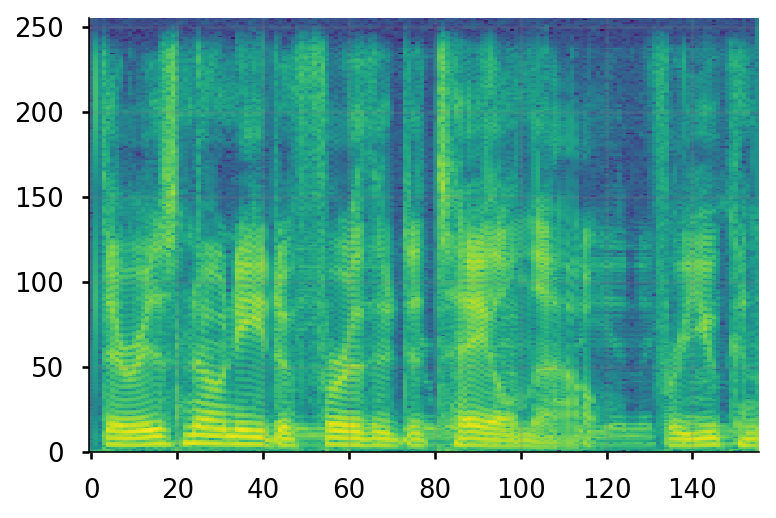

In [15]:
mpdr_tf_beamformers = compute_mvdr_tf_beamformers(source_steering_vectors[:, 0, 0, :], received_stft_multichannel)
mpdr_tf_out = np.zeros((n_fft_bins, received_stft_multichannel.shape[2]), dtype=np.complex64)
for i_fft_bin in range(n_fft_bins):
    mpdr_tf_out[i_fft_bin] = mpdr_tf_beamformers[i_fft_bin].transpose().conjugate().dot(received_stft_multichannel[i_fft_bin])
t, mpdr_out = istft(mpdr_tf_out, fs=sampling_frequency, window=stft_window,
                         nperseg=n_samples_per_frame, noverlap=n_samples_per_frame-hop_size,
                         nfft=n_samples_per_frame, boundary=True)

plt.imshow(10*np.log10(np.abs(mpdr_tf_out)), origin='lower', aspect='auto')
mpdr_out_sinr = compute_sinr(source_stft_multichannel, interference_stft_multichannel, mpdr_tf_beamformers)
print("MPDR output SINR: {:.2f} dB".format(mpdr_out_sinr[0][0]))
Audio(np.real(mpdr_out), rate=sampling_frequency, autoplay=True)

MVDR output SINR: 45.34 dB


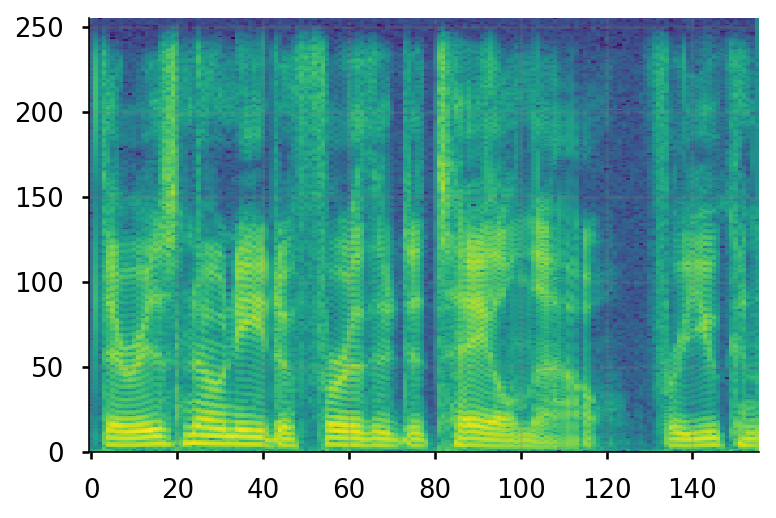

In [16]:
mvdr_tf_beamformers = compute_mvdr_tf_beamformers(source_steering_vectors[:, 0, 0, :], interference_stfts_multichannel)
mvdr_tf_out = np.zeros((n_fft_bins, received_stft_multichannel.shape[2]), dtype=np.complex64)
for i_fft_bin in range(n_fft_bins):
    mvdr_tf_out[i_fft_bin] = mvdr_tf_beamformers[i_fft_bin].transpose().conjugate().dot(received_stft_multichannel[i_fft_bin])
t, mvdr_out_2 = istft(mvdr_tf_out, fs=sampling_frequency, window=stft_window,
                         nperseg=n_samples_per_frame, noverlap=n_samples_per_frame-hop_size,
                         nfft=n_samples_per_frame, boundary=True)

plt.imshow(10*np.log10(np.abs(mvdr_tf_out)), origin='lower', aspect='auto')
mvdr_out_sinr = compute_sinr(source_stft_multichannel, interference_stft_multichannel, mvdr_tf_beamformers)
print("MVDR output SINR: {:.2f} dB".format(mvdr_out_sinr[0][0]))
Audio(np.real(mvdr_out_2), rate=sampling_frequency, autoplay=True)

In [17]:
_, _, mvdr_stft = stft(np.real(mvdr_out_2), fs=sampling_frequency, window=stft_window,
                         nperseg=n_samples_per_frame, noverlap=n_samples_per_frame-hop_size,
                         nfft=n_samples_per_frame, padded=True)
t, s = istft(mvdr_stft, fs=sampling_frequency, window=stft_window,
                         nperseg=n_samples_per_frame, noverlap=n_samples_per_frame-hop_size,
                         nfft=n_samples_per_frame, boundary=True)
Audio(np.real(s), rate=sampling_frequency, autoplay=True)

MVDR DL output SINR: 44.19 dB


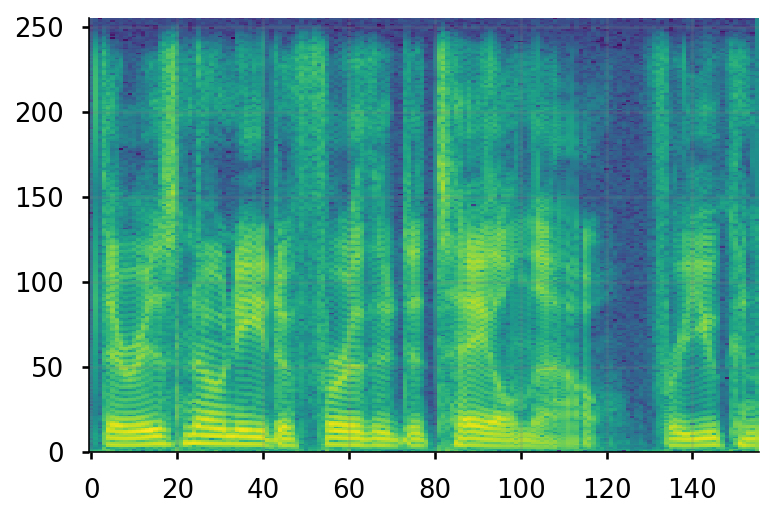

In [18]:
mvdr_dl_tf_beamformers, _ = dictionary.choose_weights(interference_stfts_multichannel)
mvdr_dl_tf_out = np.zeros((n_fft_bins, interference_stfts_multichannel.shape[2]), dtype=np.complex64)
for i_fft_bin in range(n_fft_bins):
    mvdr_dl_tf_out[i_fft_bin] = mvdr_dl_tf_beamformers[i_fft_bin].transpose().conjugate().dot(received_stft_multichannel[i_fft_bin])
t, mvdr_dl_out = istft(mvdr_dl_tf_out, fs=sampling_frequency, window=stft_window,
                         nperseg=n_samples_per_frame, noverlap=n_samples_per_frame-hop_size,
                         nfft=n_samples_per_frame, boundary=True)

plt.imshow(10*np.log10(np.abs(mvdr_dl_tf_out)), origin='lower', aspect='auto')
mvdr_dl_out_sinr = compute_sinr(source_stft_multichannel, interference_stft_multichannel, mvdr_dl_tf_beamformers)
print("MVDR DL output SINR: {:.2f} dB".format(mvdr_dl_out_sinr[0][0]))
Audio(np.real(mvdr_dl_out), rate=sampling_frequency, autoplay=True)

MPDR DL output SINR: 44.19 dB


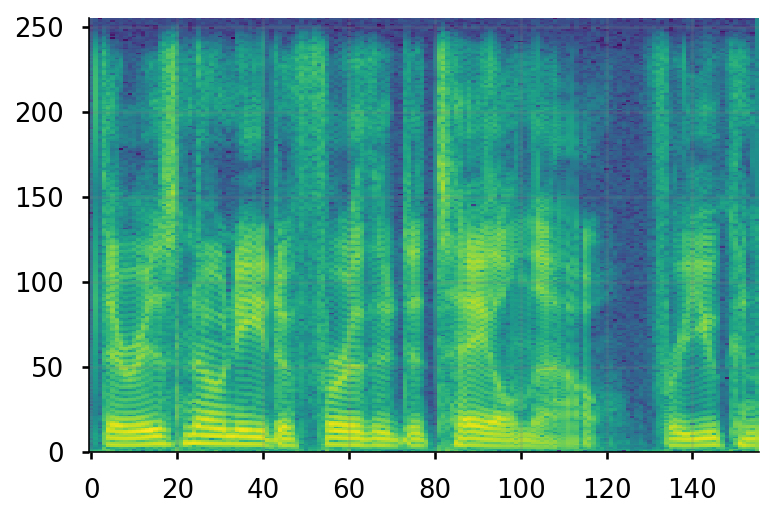

In [19]:
mpdr_dl_tf_beamformers, _ = dictionary.choose_weights(received_stft_multichannel)
mpdr_dl_tf_out = np.zeros((n_fft_bins, received_stft_multichannel.shape[2]), dtype=np.complex64)
for i_fft_bin in range(n_fft_bins):
    mpdr_dl_tf_out[i_fft_bin] = mpdr_dl_tf_beamformers[i_fft_bin].transpose().conjugate().dot(received_stft_multichannel[i_fft_bin])
t, mpdr_dl_out = istft(mpdr_dl_tf_out, fs=sampling_frequency, window=stft_window,
                         nperseg=n_samples_per_frame, noverlap=n_samples_per_frame-hop_size,
                         nfft=n_samples_per_frame, boundary=True)

plt.imshow(10*np.log10(np.abs(mpdr_dl_tf_out)), origin='lower', aspect='auto')
mpdr_dl_out_sinr = compute_sinr(source_stft_multichannel, interference_stft_multichannel, mpdr_dl_tf_beamformers)
print("MPDR DL output SINR: {:.2f} dB".format(mpdr_dl_out_sinr[0][0]))
Audio(np.real(mpdr_dl_out), rate=sampling_frequency, autoplay=True)

### Steered response

###### DS beamformers aim to emphasize target angles and not to create nulls.

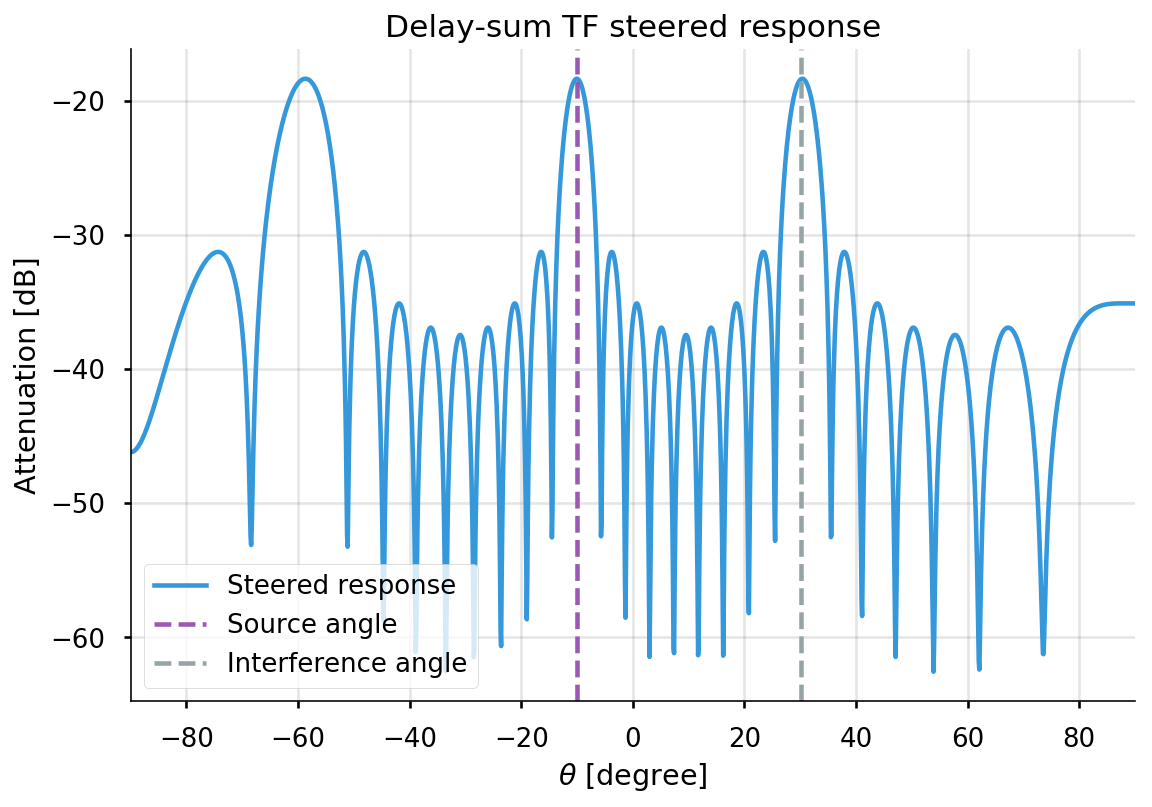

In [20]:
# Delay-sum steered response
ds_tf_S = np.zeros((n_fft_bins, len(theta_grid), len(phi_grid)), dtype=np.complex64)
for i_fft_bin in range(n_fft_bins):
    sample_tf_covariance_matrix = 1./n_test_samples * ( received_stft_multichannel[i_fft_bin].dot(received_stft_multichannel[i_fft_bin].transpose().conjugate()) )
    for i_theta in range(len(theta_grid)):
        for i_phi in range(len(phi_grid)):
            scanning_steering_vector = steering_vectors[i_fft_bin][i_theta][i_phi]
            ds_tf_S[i_fft_bin][i_theta][i_phi] = (1./n_mics * scanning_steering_vector).transpose().conjugate().dot(
                sample_tf_covariance_matrix).dot(1./n_mics * scanning_steering_vector)

ds_tf_S_normalized = np.abs(ds_tf_S)/np.max(np.abs(ds_tf_S))
ds_tf_S_db = 10*np.log10(ds_tf_S_normalized);

fig = plt.figure(figsize=(9, 6)); ax = fig.add_subplot(111)
ax.plot(theta_grid, ds_tf_S_db[40, :, 0], label="Steered response");
ax.axvline(x=theta_s[0], linestyle="--", color=flatui[1], label="Source angle");
for i_interference in range(0, len(thetas_i)):
    ax.axvline(x=thetas_i[i_interference], linestyle="--", color=flatui[i_interference+2], label="Interference angle");
ax.set_xlim(-90, 90);
ax.set_xlabel(r"$\theta$ [degree]"); ax.set_ylabel("Attenuation [dB]");
ax.set_title("Delay-sum TF steered response")
ax.legend();

###### MVDR places nulls at interference directions

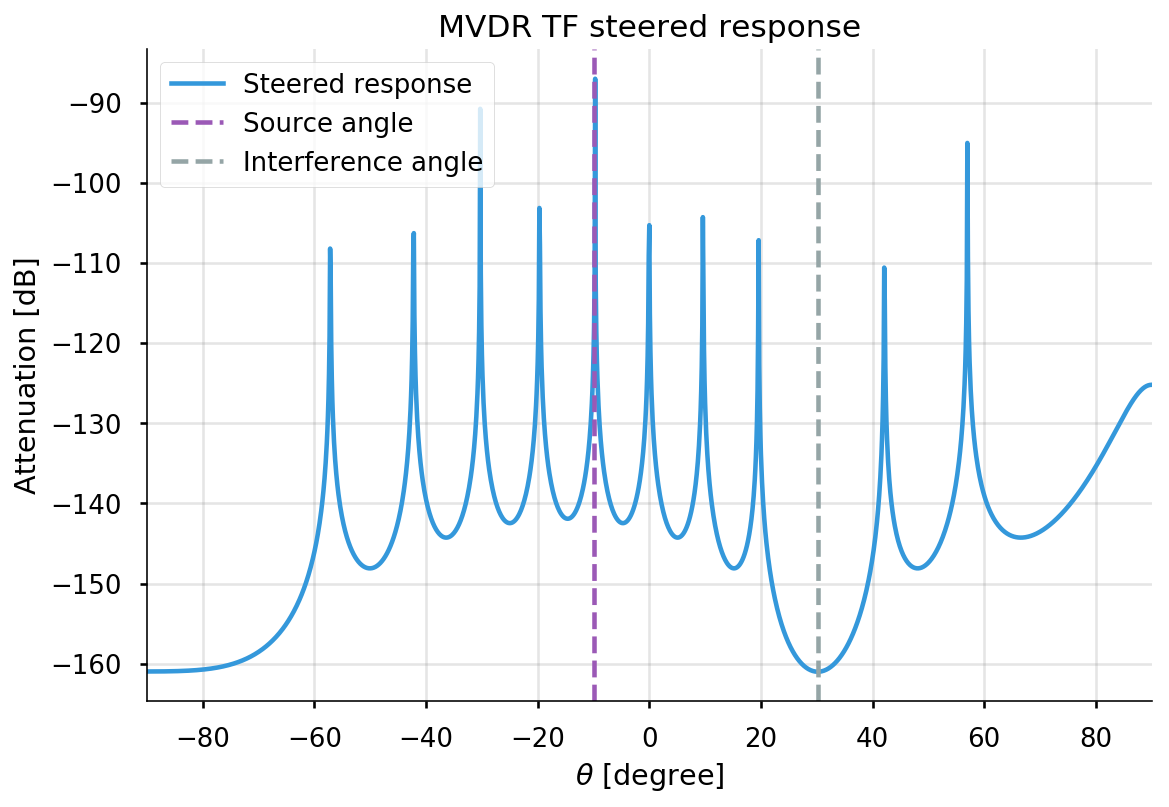

In [21]:
# MVDR steered response
mvdr_dl_tf_S = np.zeros((n_fft_bins, len(theta_grid), len(phi_grid)), dtype=np.complex64)
for i_fft_bin in range(n_fft_bins):
    sample_tf_covariance_matrix = 1./n_test_samples * ( interference_stft_multichannel[i_fft_bin].dot(interference_stft_multichannel[i_fft_bin].transpose().conjugate()) )
    for i_theta in range(len(theta_grid)):
        for i_phi in range(len(phi_grid)):
            scanning_steering_vector = steering_vectors[i_fft_bin][i_theta][i_phi]
            mvdr_dl_tf_S[i_fft_bin][i_theta][i_phi] = 1 / ((scanning_steering_vector).transpose().conjugate().dot(
                sample_tf_covariance_matrix).dot(scanning_steering_vector))

mvdr_tf_S_normalized = np.abs(mvdr_dl_tf_S)/np.max(np.abs(mvdr_dl_tf_S))
mvdr_tf_S_db = 10*np.log10(mvdr_tf_S_normalized);

fig = plt.figure(figsize=(9, 6)); ax = fig.add_subplot(111)
ax.plot(theta_grid, mvdr_tf_S_db[18, :, 0], label="Steered response");
ax.axvline(x=theta_s[0], linestyle="--", color=flatui[1], label="Source angle");
for i_interference in range(0, len(thetas_i)):
    ax.axvline(x=thetas_i[i_interference], linestyle="--", color=flatui[i_interference+2], label="Interference angle");
ax.set_xlim(-90, 90);
ax.set_xlabel(r"$\theta$ [degree]"); ax.set_ylabel("Attenuation [dB]");
ax.set_title("MVDR TF steered response")
ax.legend();